In [22]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

In [23]:
from api import bingx as api_entry
import indicator

In [24]:
kLine = api_entry.get_kLine_data("BTC-USDT", "4h", 100)
btc_i = indicator.Indicators('BTC-USDT', 4 * 60 * 60 * 1000)
btc_i.import_kLines(kLine)
# close = pd.Series(np.array([float(item["close"]) for item in kLine]))

In [25]:
close = btc_i.kLines_pd["close"]
rsi = btc_i.kLines_pd["RSI"]
print(rsi)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
        ...    
95    54.854886
96    50.266889
97    48.977274
98    50.531912
99    48.062738
Name: RSI, Length: 100, dtype: float64


In [26]:
# 假設 close 是一個 pandas Series，代表收盤價
# 產生測試資料
# np.random.seed(0)
# close = pd.Series(np.sin(np.linspace(0, 10*np.pi, 100)) + np.random.normal(0, 0.2, 100))

In [27]:
# 設定滑動窗口大小
order = 3  # 周圍看 3 根K棒作比較

In [28]:
# 找出局部極大值與極小值的索引
local_max_idx = argrelextrema(close.values, np.greater, order=order)[0]
local_min_idx = argrelextrema(close.values, np.less, order=order)[0]
local_max_idx_rsi = argrelextrema(rsi.values, np.greater, order=order)[0]
local_min_idx_rsi = argrelextrema(rsi.values, np.less, order=order)[0]

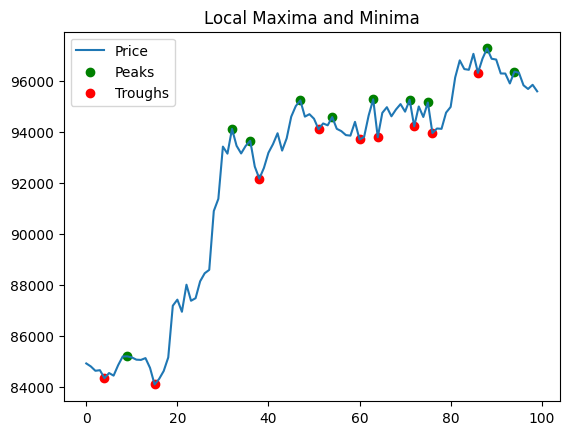

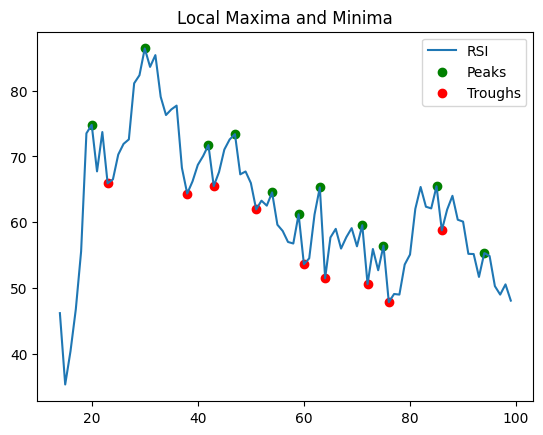

In [29]:
# 繪圖顯示
plt.plot(close, label='Price')
plt.scatter(local_max_idx, close.iloc[local_max_idx], color='green', label='Peaks')
plt.scatter(local_min_idx, close.iloc[local_min_idx], color='red', label='Troughs')
plt.legend()
plt.title('Local Maxima and Minima')
plt.show()

# 繪圖顯示
plt.plot(rsi, label='RSI')
plt.scatter(local_max_idx_rsi, rsi.iloc[local_max_idx_rsi], color='green', label='Peaks')
plt.scatter(local_min_idx_rsi, rsi.iloc[local_min_idx_rsi], color='red', label='Troughs')
plt.legend()
plt.title('Local Maxima and Minima')
plt.show()

In [30]:
same_high = []
min_i = 0
l = len(local_max_idx_rsi)
for i, v in enumerate(local_max_idx):
    for i2 in range(min_i, l):
        # print(f"({v}, {i2})", end=" ")
        if abs(v - local_max_idx_rsi[i2]) <= 1: # K high index is equal to RSI high index
            same_high.append(v)
            min_i = i2
            break
        elif local_max_idx_rsi[i2] > v:
            min_i = i2
            break
    # print("")

In [31]:
same_low = []
min_i = 0
l = len(local_min_idx_rsi)
for i, v in enumerate(local_min_idx):
    for i2 in range(min_i, l):
        # print(f"({v}, {i2})", end=" ")
        if abs(v - local_min_idx_rsi[i2]) <= 1: # K high index is equal to RSI high index
            same_low.append(v)
            min_i = i2
            break
        elif local_min_idx_rsi[i2] > v:
            min_i = i2
            break
    # print("")

In [33]:
print(f"RSI, Price same high points: {same_high}")
print(f"RSI, Price same low points: {same_low}")

RSI, Price same high points: [47, 54, 63, 71, 75, 94]
RSI, Price same low points: [38, 51, 60, 64, 72, 76, 86]


In [34]:
def find_rsi_divergences(price, rsi, high_points, low_points):
    divergences = []

    # 判斷看跌背離（高點）
    for i in range(len(high_points) - 1):
        idx1, idx2 = high_points[i], high_points[i+1]
        p1, p2 = price[idx1], price[idx2]
        r1, r2 = rsi[idx1], rsi[idx2]

        if p2 > p1 and r2 < r1:
            divergences.append({
                'type': 'bearish',
                'start': idx1,
                'end': idx2,
                'price1': p1,
                'price2': p2,
                'rsi1': r1,
                'rsi2': r2
            })

    # 判斷看漲背離（低點）
    for i in range(len(low_points) - 1):
        idx1, idx2 = low_points[i], low_points[i+1]
        p1, p2 = price[idx1], price[idx2]
        r1, r2 = rsi[idx1], rsi[idx2]

        if p2 < p1 and r2 > r1:
            divergences.append({
                'type': 'bullish',
                'start': idx1,
                'end': idx2,
                'price1': p1,
                'price2': p2,
                'rsi1': r1,
                'rsi2': r2
            })

    return divergences


In [35]:
divs = find_rsi_divergences(btc_i.kLines_pd["close"], btc_i.kLines_pd["RSI"], same_high, same_low)
for d in divs:
    print(f"{d['type'].upper()} divergence from {d['start']} to {d['end']}")

BEARISH divergence from 75 to 94
